###TAXI WEEK #3 SHITKOV

In [0]:
%pylab inline
from scipy import stats
import statsmodels.api as sm
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from datetime import datetime
from scipy import stats
import statsmodels.api as sm
from google.colab import drive
drive.mount('/content/gdrive')

Populating the interactive namespace from numpy and matplotlib
Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


####1. 1. Возьмём даные c марта по май 2016 года, ячейку region_1231

In [0]:
filepath = '/content/gdrive/My Drive/ml/'
month = ['2016-3' ,'2016-4' ,'2016-5']
month_arr = []
for m in range(len(month)):
  filename = str(month[m]) + str('.csv')
  data = pd.read_csv(filepath + filename, index_col = 0)
  month_arr.append(pd.DataFrame(data.region_1231, index = [datetime.strptime(i, '%Y-%m-%d %H:%M:%S') for i in data.index]))

data = pd.concat(month_arr)  

<Figure size 1296x1152 with 0 Axes>

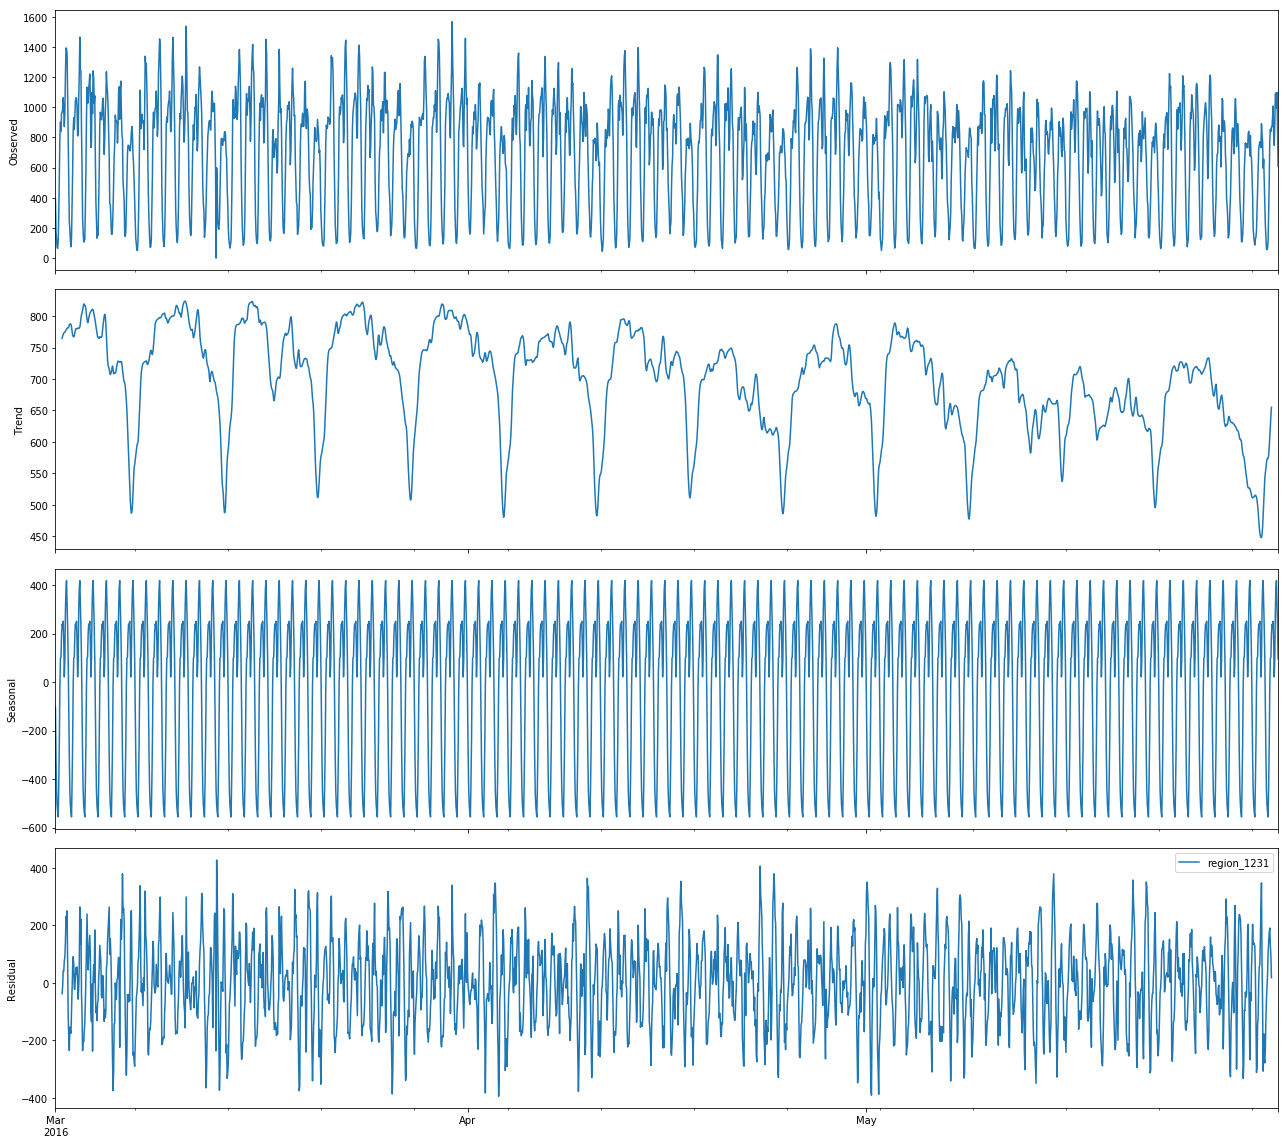

In [0]:
figure(figsize(18,16))
sm.tsa.seasonal_decompose(data.region_1231).plot()
legend()
show()

####1.2.  Регрессионные признаки для учёта сезонностей и трендов.

Рассчитаем по приведенным формулам признаки и сформируем новый датасет

$s_i = \sin \left( [1,\dots,T] * 2 \pi i/ 168 \right), $

$c_i = \cos \left( [1,\dots,T] * 2 \pi i/ 168 \right), $

$i=1,\dots, K.$

Здесь $T$— это длина моделируемого ряда в часах, 168 — длительность недели в часах, а значение параметра K предстоит подобрать самостоятельно (в зависимости от длины подготовленного ряда, можно для начала взять $K$ равным 2-5).

In [0]:
#функция для различных K
def k_features(data_in, k):
  data = data_in
  data['num'] = [int(i)  for i in range(1, len(data) + 1)]
  ind = []
  
  for i in range(1, k + 1):
    data[str('sin_' + str(i))] = [np.sin(data.num[x] * 2 * np.pi * i / 168) for x in range(len(data))]
    data[str('cos_' + str(i))] = [np.cos(data.num[x] * 2 * np.pi * i / 168) for x in range(len(data))]
    ind.append(str('sin_' + str(i)))
    ind.append(str('cos_' + str(i)))
  
  return data, ind

k = 7
data, ind_k = k_features(data, k)

In [0]:
data.head()

region_1231  num     sin_1  ...     cos_6     sin_7     cos_7
2016-03-01 00:00:00        389.0    1  0.037391  ...  0.974928  0.258819  0.965926
2016-03-01 01:00:00        178.0    2  0.074730  ...  0.900969  0.500000  0.866025
2016-03-01 02:00:00        128.0    3  0.111964  ...  0.781831  0.707107  0.707107
2016-03-01 03:00:00         70.0    4  0.149042  ...  0.623490  0.866025  0.500000
2016-03-01 04:00:00         65.0    5  0.185912  ...  0.433884  0.965926  0.258819

[5 rows x 16 columns]

####2. Чтобы примерно подобрать порядки дифференцирования ряда в модели ARIMA, сделайте регрессию целевого признака — количества поездок — на построенные признаки. Посмотрите на остатки регрессии. Если регрессионные признаки подобраны идеально, то в них должна остаться только внутрисуточная сезонность. Вслепую идеально подобрать признаки вам вряд ли удастся, так что в остатках вы, скорее всего, увидите много интересного, в том числе праздники, аномалии, тренды и многое другое.

In [0]:
X = np.array(data[ind_k])
Y = np.array(data.region_1231)

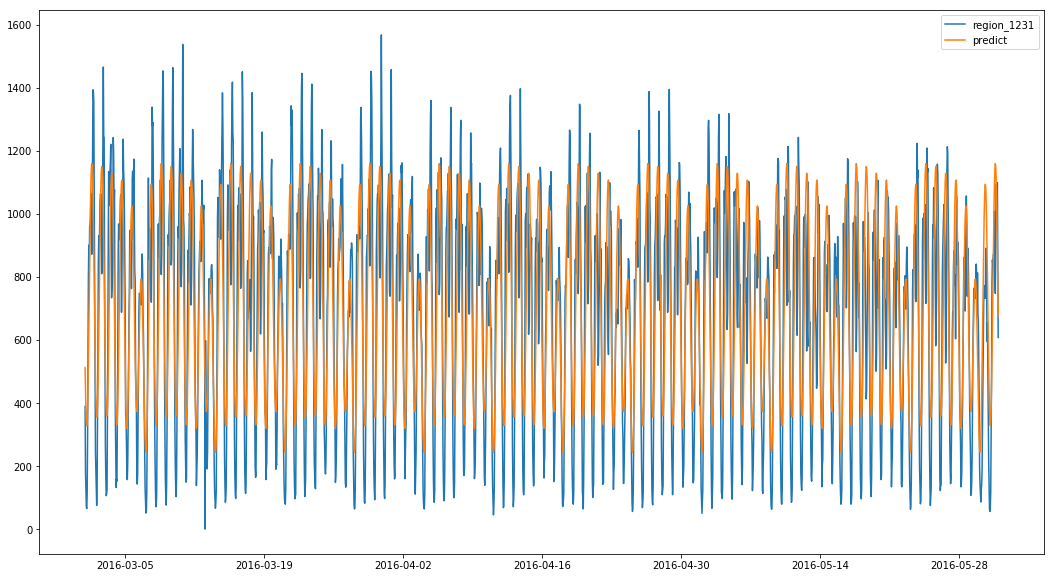

In [0]:
#Регрессия целевого признака

#1. Обучить модель
from sklearn import linear_model
lin_reg = linear_model.LinearRegression()
lin_reg.fit(X,Y)

#2. Получить значения
data['predict'] = lin_reg.predict(data[ind_k])

#3. Получить остатки как разность исхоных данных и расчёта модели
figure(figsize=(18,10))
plot(data.index,data.region_1231)
plot(data.index,data.predict)
# data.region_1231.rolling(24).mean().plot()
# data.predict.rolling(24).mean().plot()
legend()
show()

Аппроксимация откровенно плохая - просто повторяется недельный паттерн.

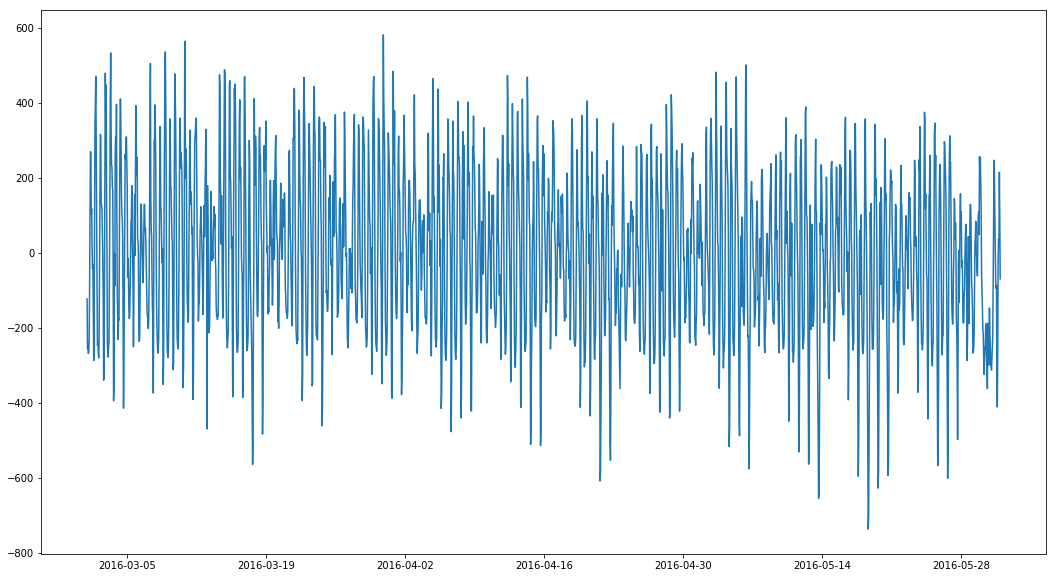

In [0]:
#остатки
data['remains'] = data.region_1231 - data.predict

figure(figsize=(18,10))
plot(data.index,data.remains)
show()

<Figure size 1296x1152 with 0 Axes>

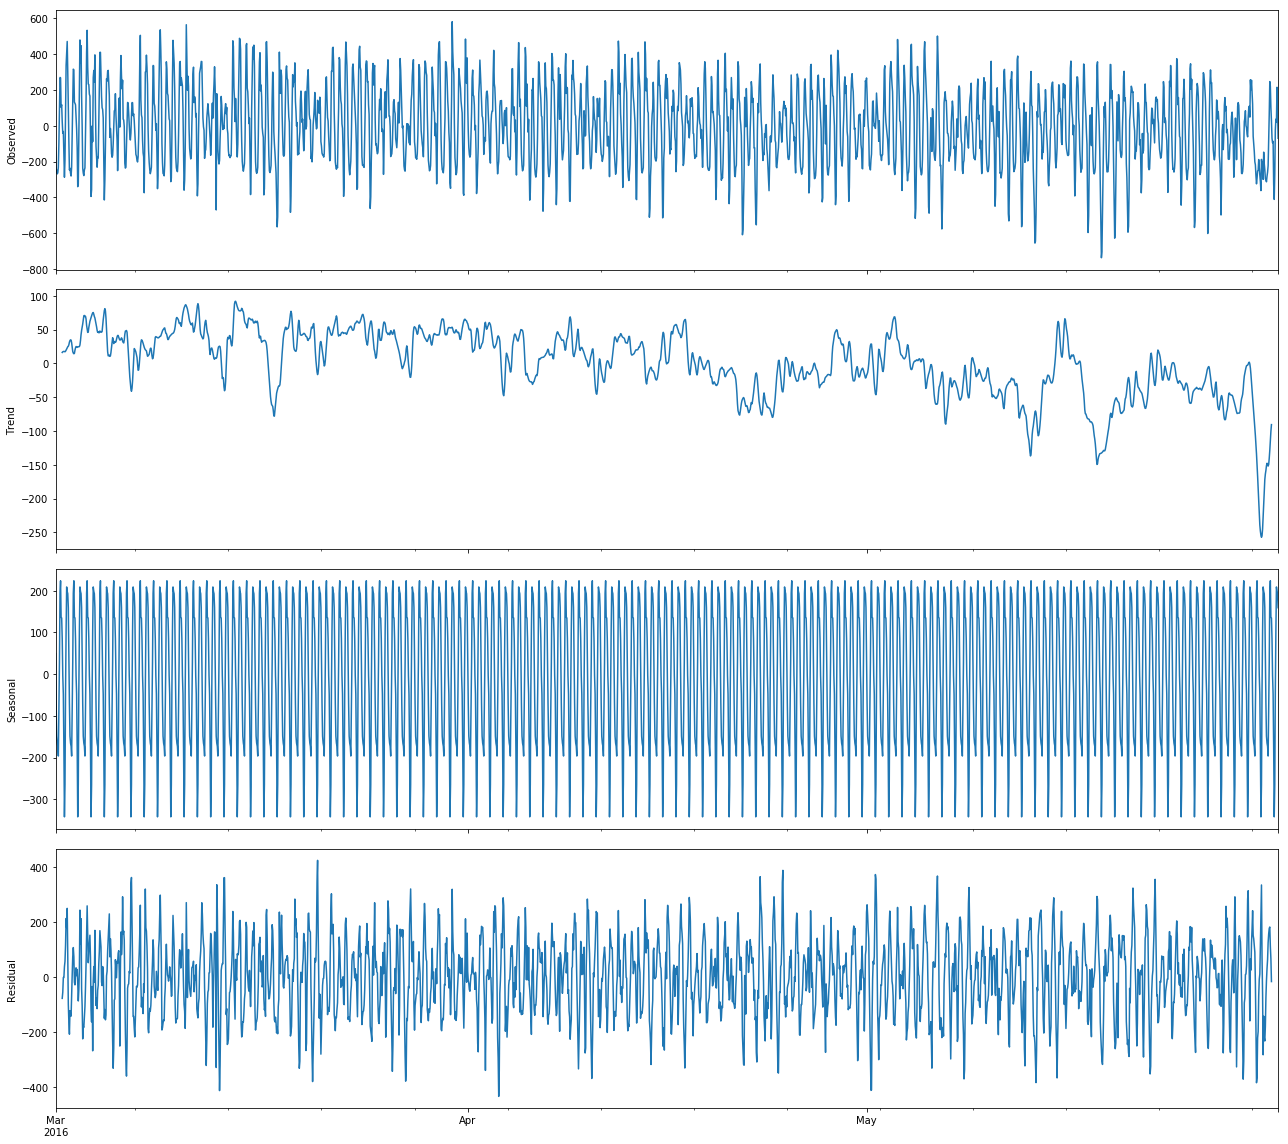

In [0]:
#анализ остатков
figure(figsize(18,16))
sm.tsa.seasonal_decompose(data.remains).plot()
show()

Визуально в остатках присутствует суточная сезонность

####3. Чтобы подобрать значения гиперпараметров ARIMA, попробуйте сделать ряд остатков стационарным. Если необходимо, сделайте несколько дифференцирований. Из-за большого количества аномальных дней (праздники и т.д.) вряд ли вам удастся сделать так, что критерий Дики-Фуллера не будет отвергать гипотезу нестационарности, поэтому при выборе порядка дифференцирования ориентируйтесь в первую очередь на результат STL-декомпозиции.

<Figure size 1296x1152 with 0 Axes>

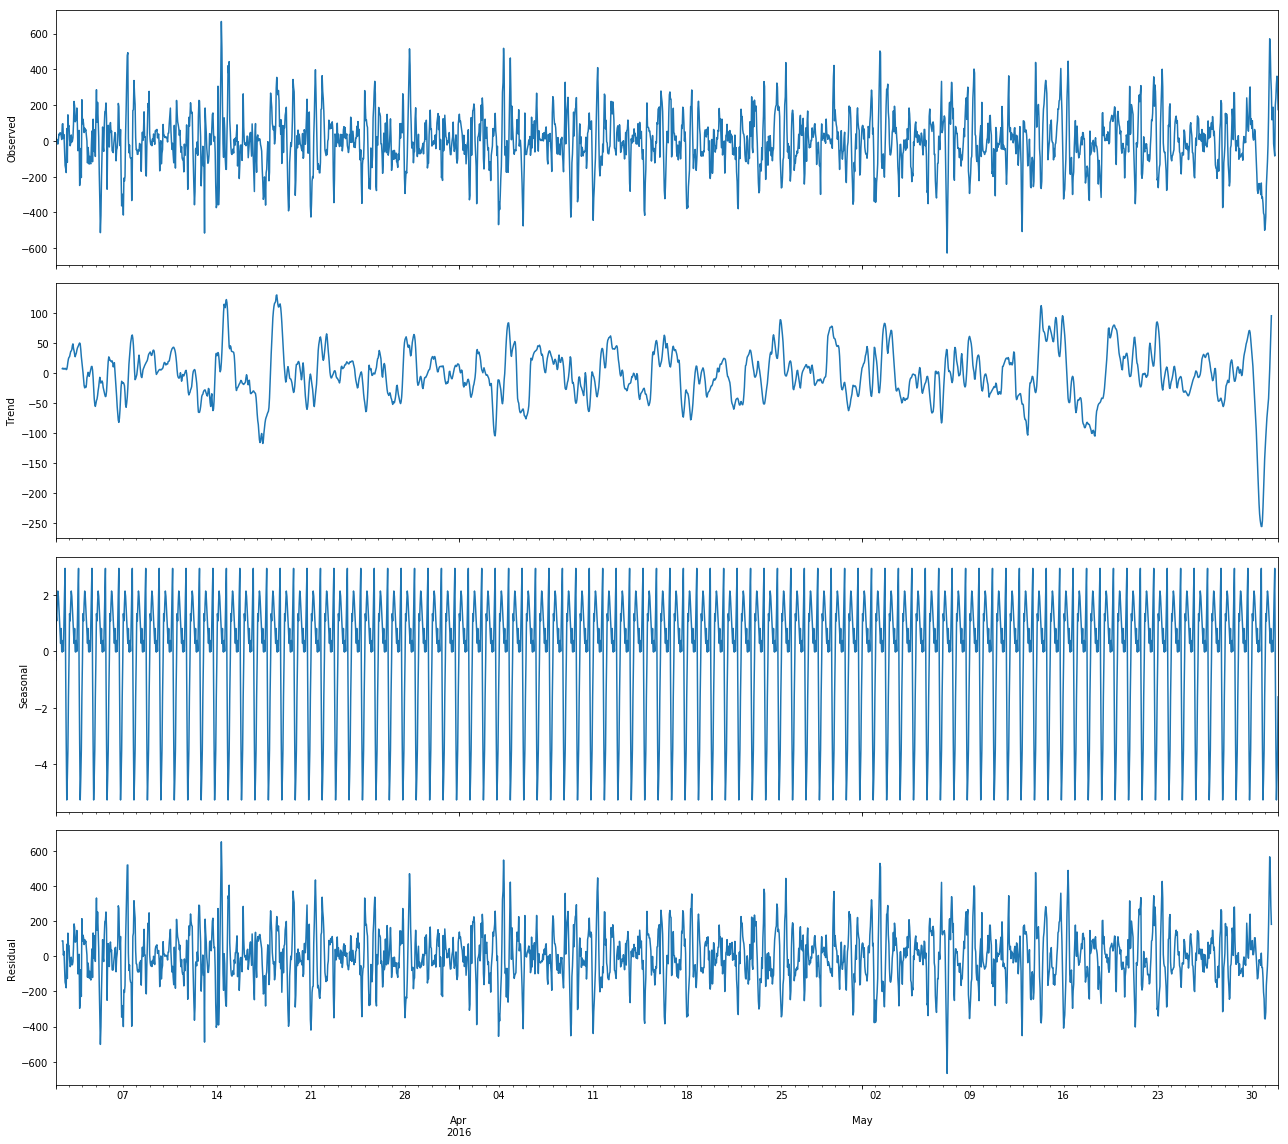

In [0]:
#применим диференцирование ряда со сдвигом на 24 часа
data['diff'] = data.remains - data.remains.shift(24)

figure(figsize(18,16))
sm.tsa.seasonal_decompose(data['diff'].dropna()).plot()
show()

Визуально суточная сезонность уменьшилась.

<Figure size 1296x1152 with 0 Axes>

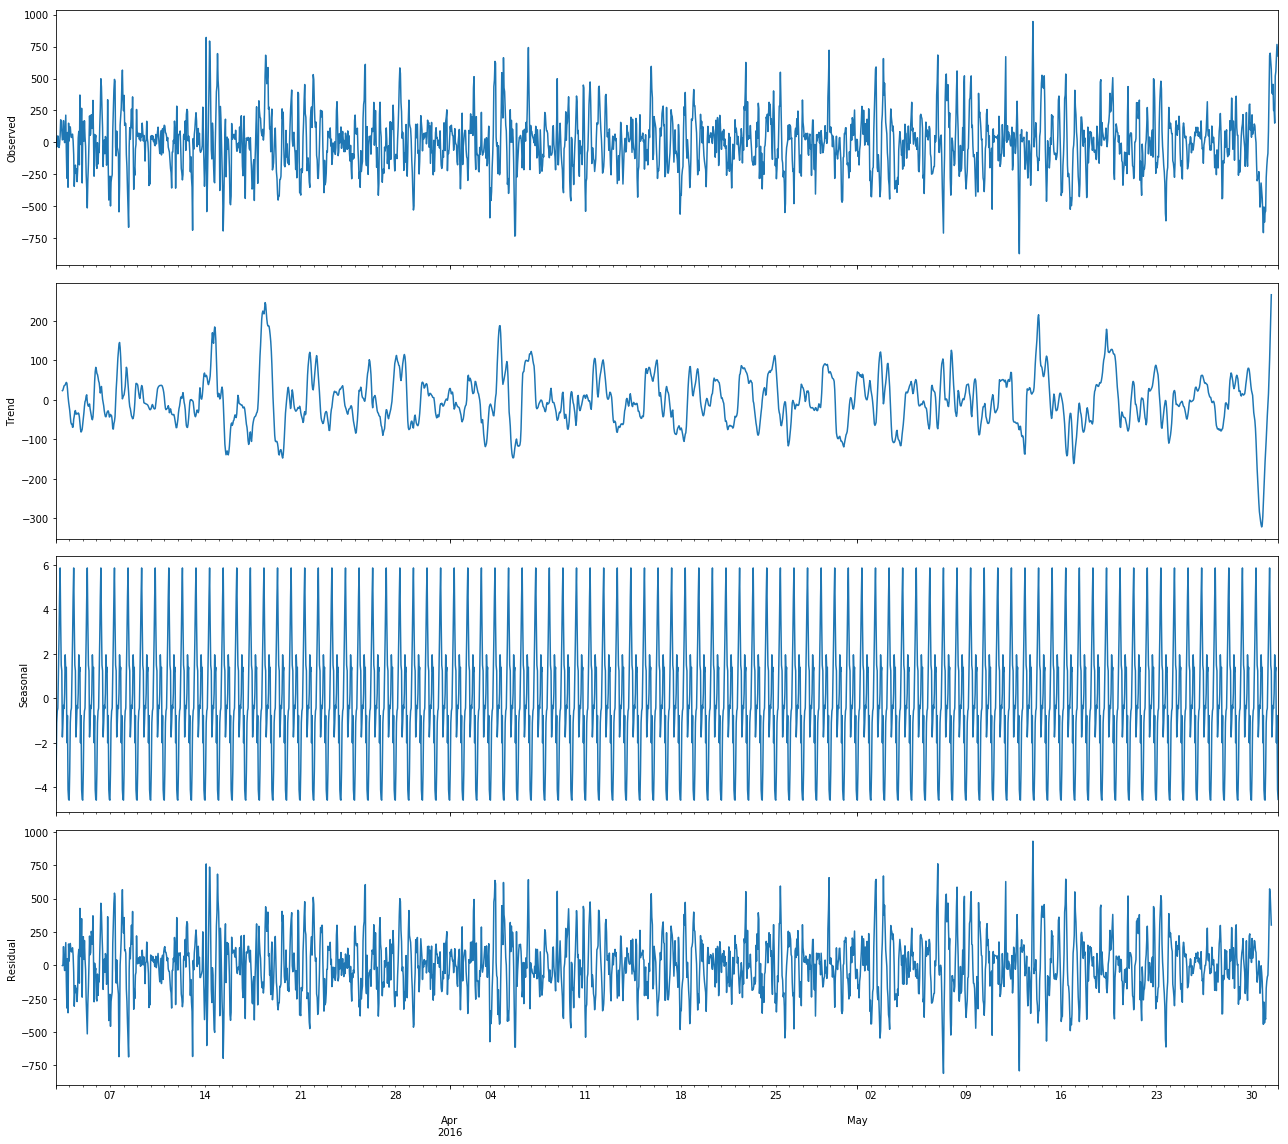

In [0]:
#применим еще раз диференцирование ряда со сдвигом на 24 часа
data['diff'] = data['diff'] - data['diff'].shift(24)

figure(figsize(18,16))
sm.tsa.seasonal_decompose(data['diff'].dropna()).plot()
show()

In [0]:
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(data['diff'].dropna())[1])

Критерий Дики-Фуллера: p=0.000000


####4. Постройте ACF и PACF полученного ряда остатков (возможно, продифференцированных) с максимальным лагом не меньше длины самого длинного сезонного периода (неделя или год), подберите по ним начальные приближения для параметров p,q,P,Q. Используйте эти начальные приближения при переборе моделей ARIMA исходного ряда, не забывая подавать функции SARIMAX регрессионные признаки в качестве параметра exog.

<Figure size 2160x720 with 0 Axes>

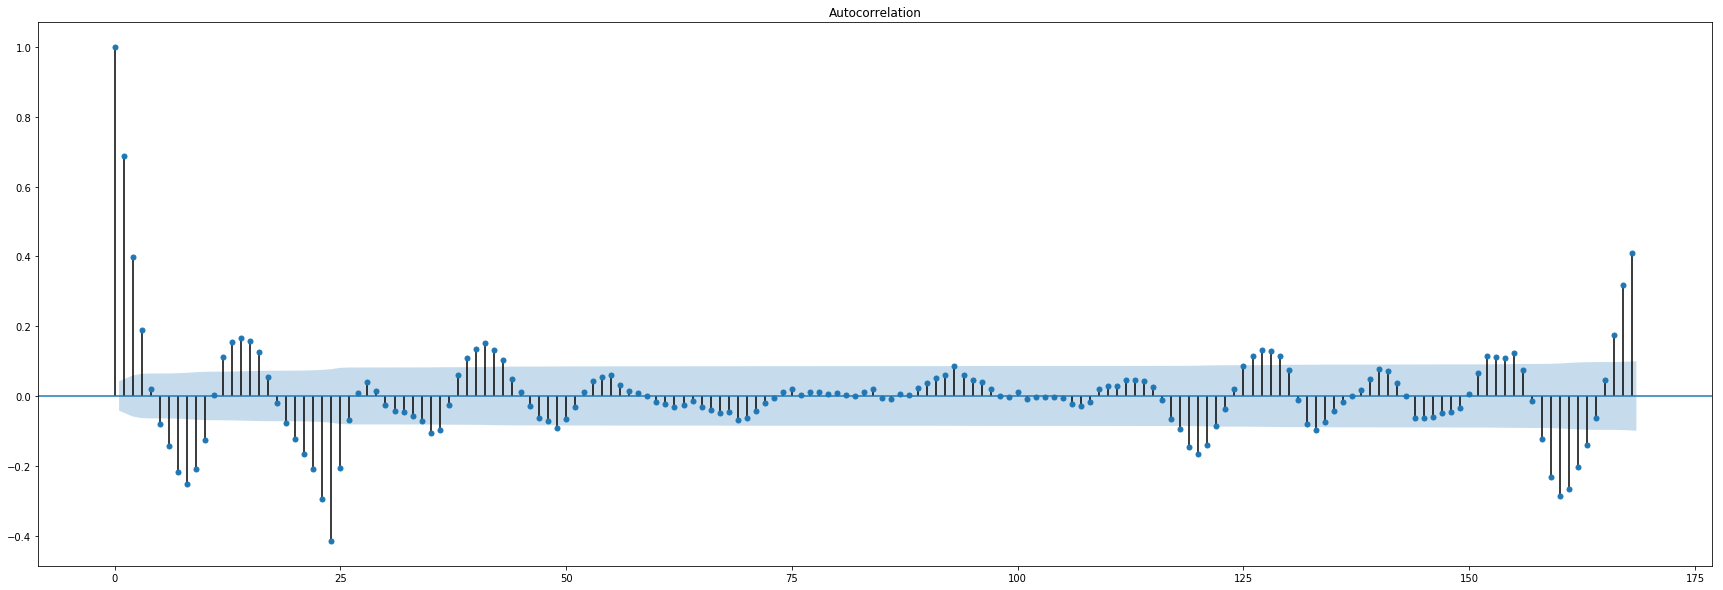

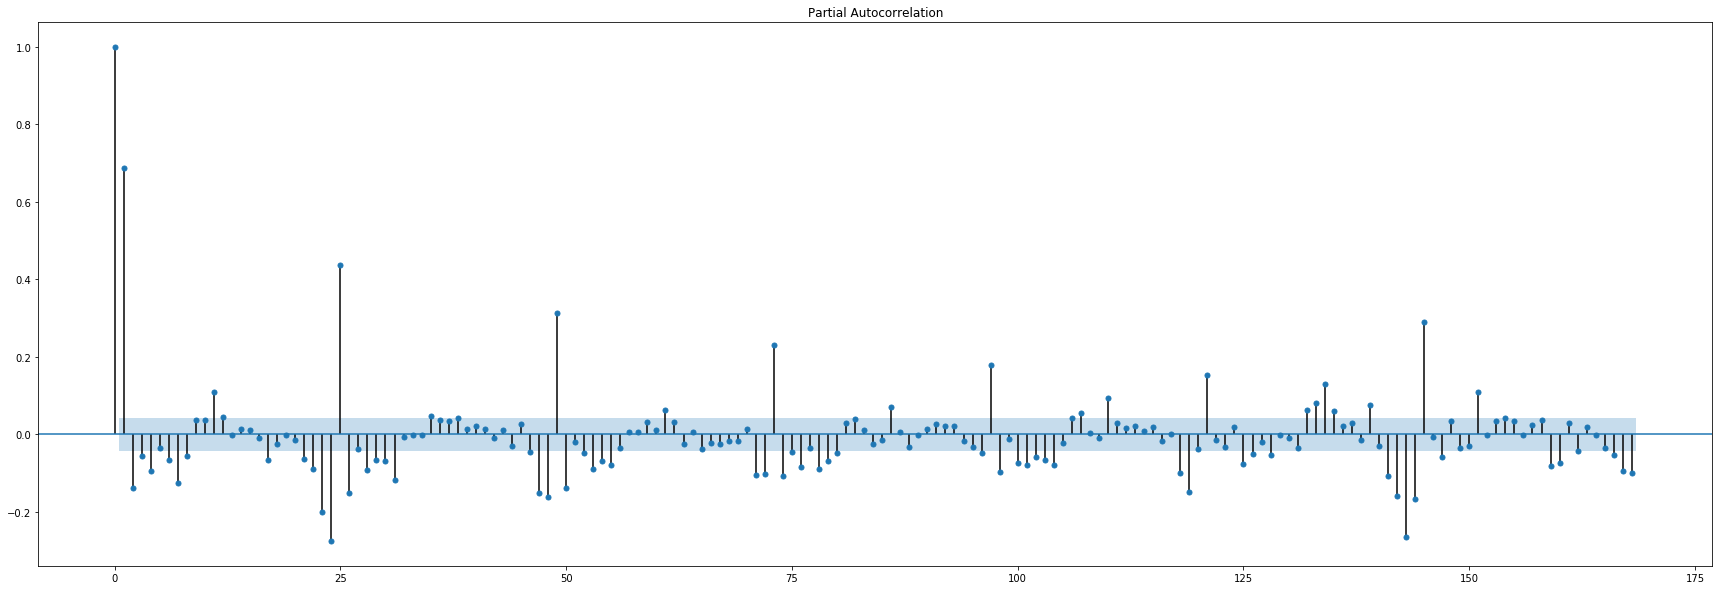

In [0]:
import statsmodels.api as sm
#ACF и PACF полученного ряда остатков
figure(figsize(30,10))
sm.graphics.tsa.plot_acf(data['diff'].dropna().values, lags=168)
sm.graphics.tsa.plot_pacf(data['diff'].dropna().values, lags=168)
show()

Период равен 24 часа, начальные приближения:
* p = 2: последний в пределах периода 24 на PACF
* q = 2 : последний несезонный лаг со значимой автокореляцией на ACF
* P = 1  : максимальный значимый лаг кратный 24 на графике
* Q = 1  : Сезонный период равен 24, а максимальный значимый лаг, кратный 24 на графике ACF
* d = 0  :  Обычное дифференцирование
* D = 2  : Сезонное дифференцирование

In [0]:
#Диапазон значения для моделей

import warnings
from itertools import product

ps = range(0, 3)
d=0
qs = range(0, 3)
Ps = range(0, 2)
D=2
Qs = range(0, 2)

parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
print "MODELS: ", len(parameters_list)

MODELS:  36


In [0]:
#Перебор моделей
%%time
results = []
best_aic = float("inf")
warnings.filterwarnings('ignore')


#p = 21, d = 1, q = 22, P = 0, D = 2, Q = 0
#parameters_list = [(2,1,1,1)]

for param in parameters_list:
  #try except нужен, потому что на некоторых наборах параметров модель не обучается
  try:
      model=sm.tsa.statespace.SARIMAX(data['remains'].dropna(),
                                      order=(param[0], d, param[1]), 
                                      seasonal_order=(param[2], D, param[3], 24)).fit(disp=-1)
  #выводим параметры, на которых модель не обучается и переходим к следующему набору
  except Exception:
    print('Exception: ', param)
    continue        
  else:
    print(param, model.aic)
  aic = model.aic
  #сохраняем лучшую модель, aic, параметры
  if aic < best_aic:
      best_model = model
      best_aic = aic
      best_param = param
  results.append([param, model.aic])
  
warnings.filterwarnings('default')

result_table = pd.DataFrame(results)
result_table.columns = ['parameters', 'aic']
print(result_table.sort_values(by = 'aic', ascending=True).head())

print(best_model.summary())

((0, 0, 0, 0), 29451.001216933342)
((0, 0, 0, 1), 27951.060424296324)
((0, 0, 1, 0), 29019.672248430703)
((0, 0, 1, 1), 27943.81932008375)
((0, 1, 0, 0), 28395.777073231795)
((0, 1, 0, 1), 26693.422635320832)
((0, 1, 1, 0), 27787.448258419347)
((0, 1, 1, 1), 26625.656356534462)
((0, 2, 0, 0), 28148.580331554098)
((0, 2, 0, 1), 26352.838337359295)
((0, 2, 1, 0), 27454.730812260263)
((0, 2, 1, 1), 26231.724485244282)
((1, 0, 0, 0), 28066.986877245698)
((1, 0, 0, 1), 26285.631906810824)
((1, 0, 1, 0), 27395.085554261044)
((1, 0, 1, 1), 26190.56574461007)
((1, 1, 0, 0), 28033.772926466874)
((1, 1, 0, 1), 26201.680369282403)
((1, 1, 1, 0), 27308.224070276672)
((1, 1, 1, 1), 26059.754813028376)
((1, 2, 0, 0), 28032.43850666369)
((1, 2, 0, 1), 26192.94897895724)
((1, 2, 1, 0), 27301.609132971113)
((1, 2, 1, 1), 26045.405430319628)
((2, 0, 0, 0), 28028.605716806465)
((2, 0, 0, 1), 26180.801224917286)
((2, 0, 1, 0), 27288.030117276743)
((2, 0, 1, 1), 26019.65797857169)
((2, 1, 0, 0), 27992.0319

####5. Выберите оптимальную по AIC модель; постройте график исходного ряда и нарисуйте поверх предсказания выбранной модели. Если модель плохо описывает данные, попробуйте увеличить количество синусов и косинусов KKK или поменять порядки дифференцирования.

Критерий Стьюдента: p=0.464683
Критерий Дики-Фуллера: p=0.000000


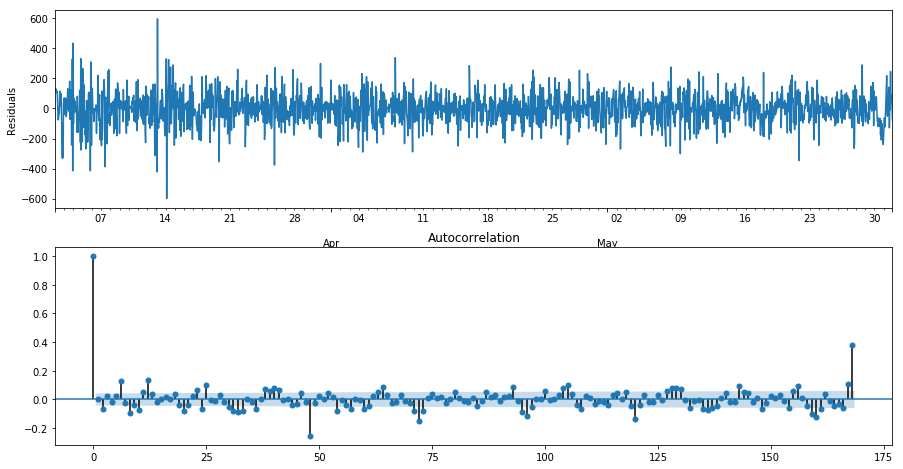

In [0]:
plt.figure(figsize(15,8))
plt.subplot(211)
best_model.resid[25:].plot()
plt.ylabel(u'Residuals')

ax = plt.subplot(212)
sm.graphics.tsa.plot_acf(best_model.resid[48:].values.squeeze(), lags=168, ax=ax)

print("Критерий Стьюдента: p=%f" % stats.ttest_1samp(best_model.resid[48:], 0)[1])
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(best_model.resid[48:])[1])

In [0]:
#Проверка автокорреляции с помощью Q-теста Льюнга — Бокса
p_val = sm.tsa.stattools.acf(best_model.resid, qstat=True)[2]
for i in range(len(p_val)):
  print round(p_val[i], 3)

0.005
0.008
0.007
0.009
0.017
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0


Остатки несмещены (подтверждается критерием Стьюдента) стационарны (подтверждается критерием Дики-Фуллера и визуально), неавтокоррелированы (подтверждается критерием Льюнга-Бокса и коррелограммой).

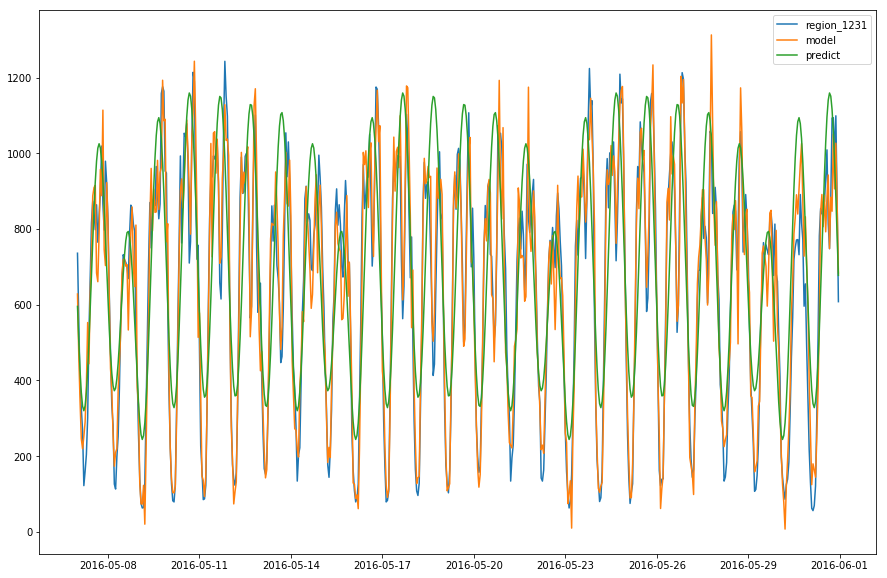

In [0]:
data['model'] = best_model.fittedvalues + data.predict

figure(figsize=(15,10))
plot(data.index[-600:],data.region_1231[-600:])
plot(data.index[-600:],data.model[-600:])
plot(data.index[-600:],data.predict[-600:])
legend()
show()

####6. Проанализируйте качество построенной модели. Опишите, в какие периоды она плохо описывает данные? Можно ли заранее предсказать её поведение в такие периоды и улучшить тем самым прогноз? Если да, попробуйте создать для таких периодов регрессионные признаки и вернитесь к пункту 2.

Суточная сезонность моделью ARIMA описывается откровенно плохо.
Добавим признаки для линейной регрессии, что бы уменьшить остатки для моделирования ARIMA

In [0]:
#Добавим полиномиальные прзнаки
for i in range(1, k + 1):
  data[str('poly_' + str(i))] = [data.num[x] ** i  for x in range(len(data))]
  ind_k.append(str('poly_' + str(i)))

In [0]:
X = np.array(data[ind_k[:-5]])
Y = np.array(data.region_1231)

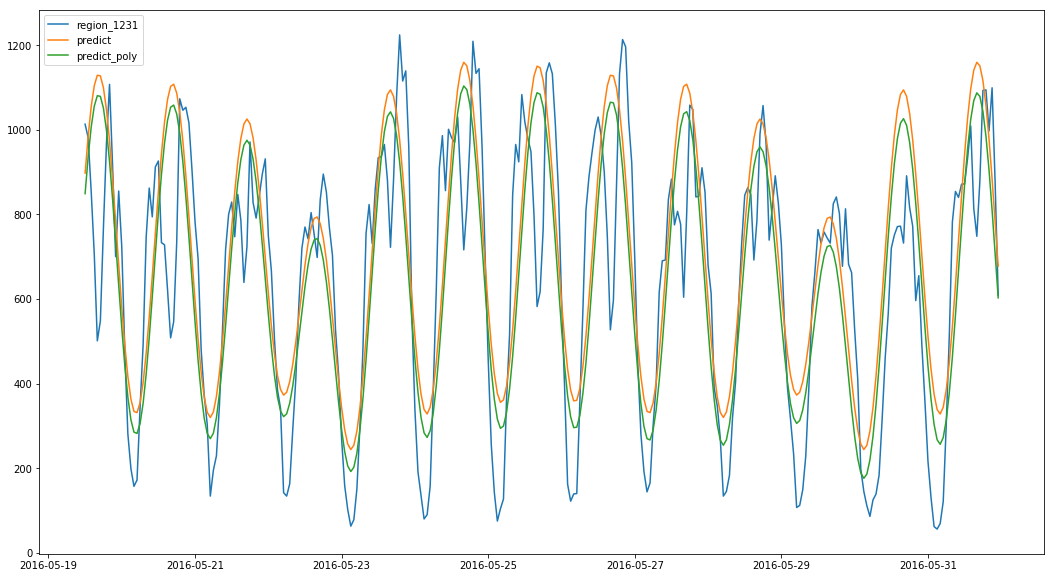

In [0]:
#Регрессия целевого признака

k_pol = 2

X  = np.array(data[ind_k[:-7]])
X2 = np.array(data[ind_k[:-7 + k_pol]])
Y  = np.array(data.region_1231)

#1. Обучить модель
from sklearn import linear_model
lin_reg = linear_model.LinearRegression()
lin_reg.fit(X,Y)

lin_reg_poly = linear_model.LinearRegression()
lin_reg_poly.fit(X2,Y)

#2. Получить значения
data['predict'] = lin_reg.predict(data[ind_k[:-7]])

data['predict_poly'] = lin_reg_poly.predict(data[ind_k[:-7 + k_pol]])

#3. Построим график
figure(figsize=(18,10))
plot(data.index[-300:],data.region_1231[-300:])
plot(data.index[-300:],data.predict[-300:])
plot(data.index[-300:],data.predict_poly[-300:])
legend()
show()

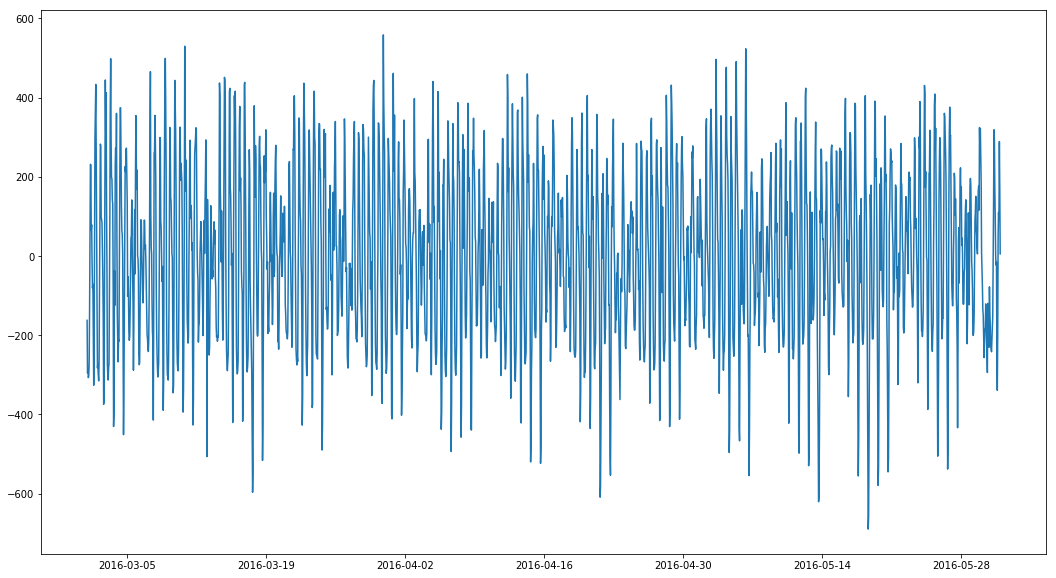

In [0]:
#остатки
data['remains_poly'] = data.region_1231 - data.predict_poly

figure(figsize=(18,10))
plot(data.index,data.remains_poly)
show()

<Figure size 1296x1152 with 0 Axes>

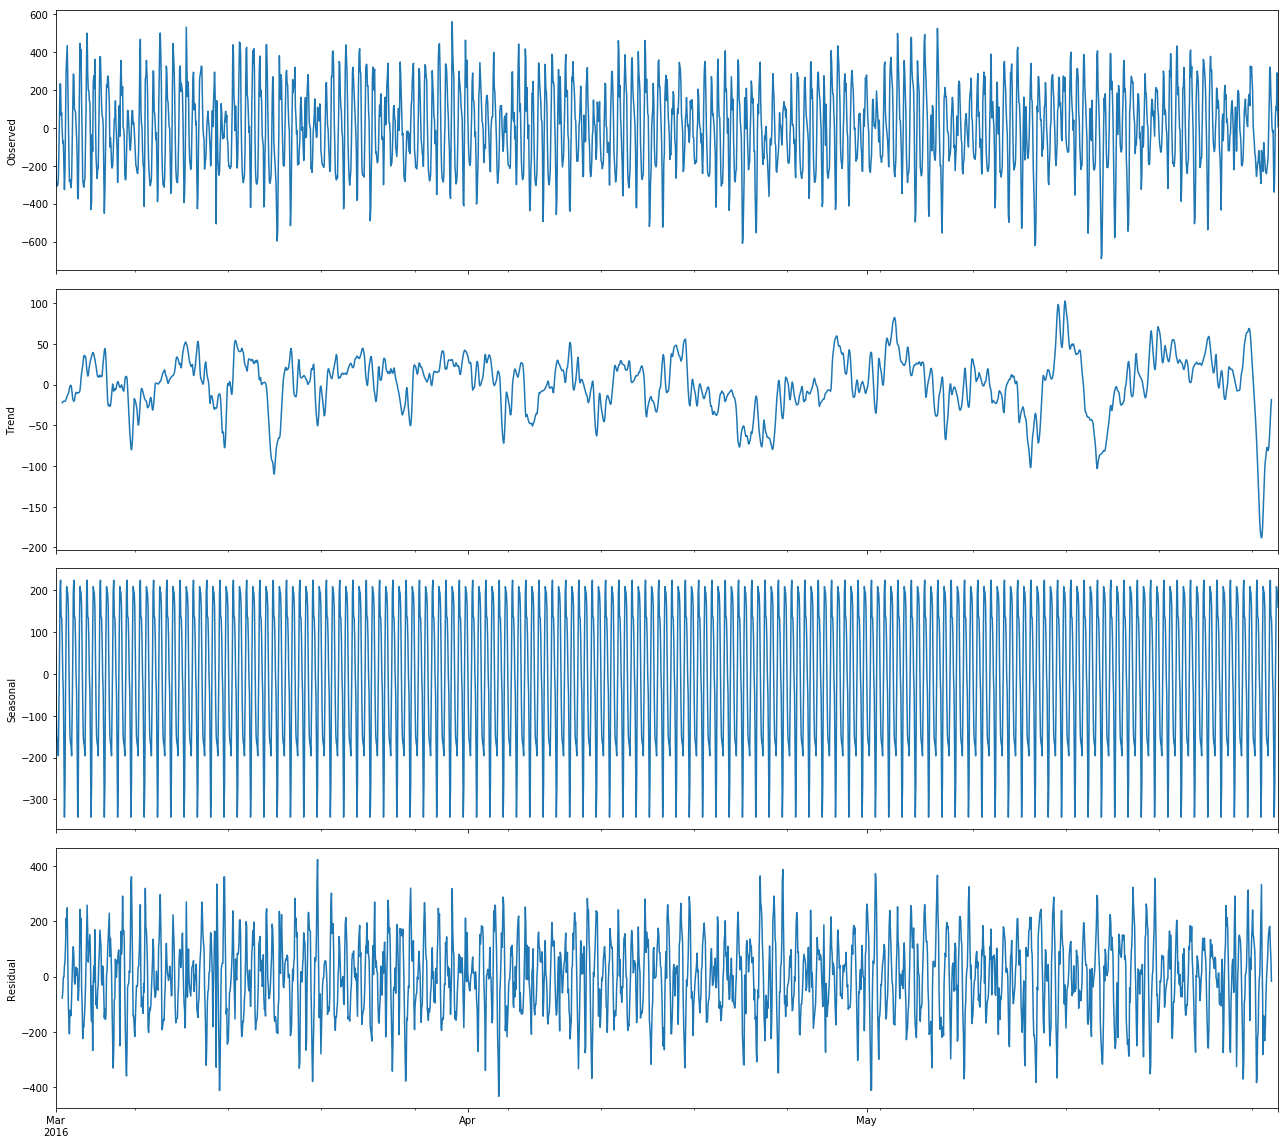

In [0]:
#анализ остатков
figure(figsize(18,16))
sm.tsa.seasonal_decompose(data.remains_poly).plot()
show()

<Figure size 1296x1152 with 0 Axes>

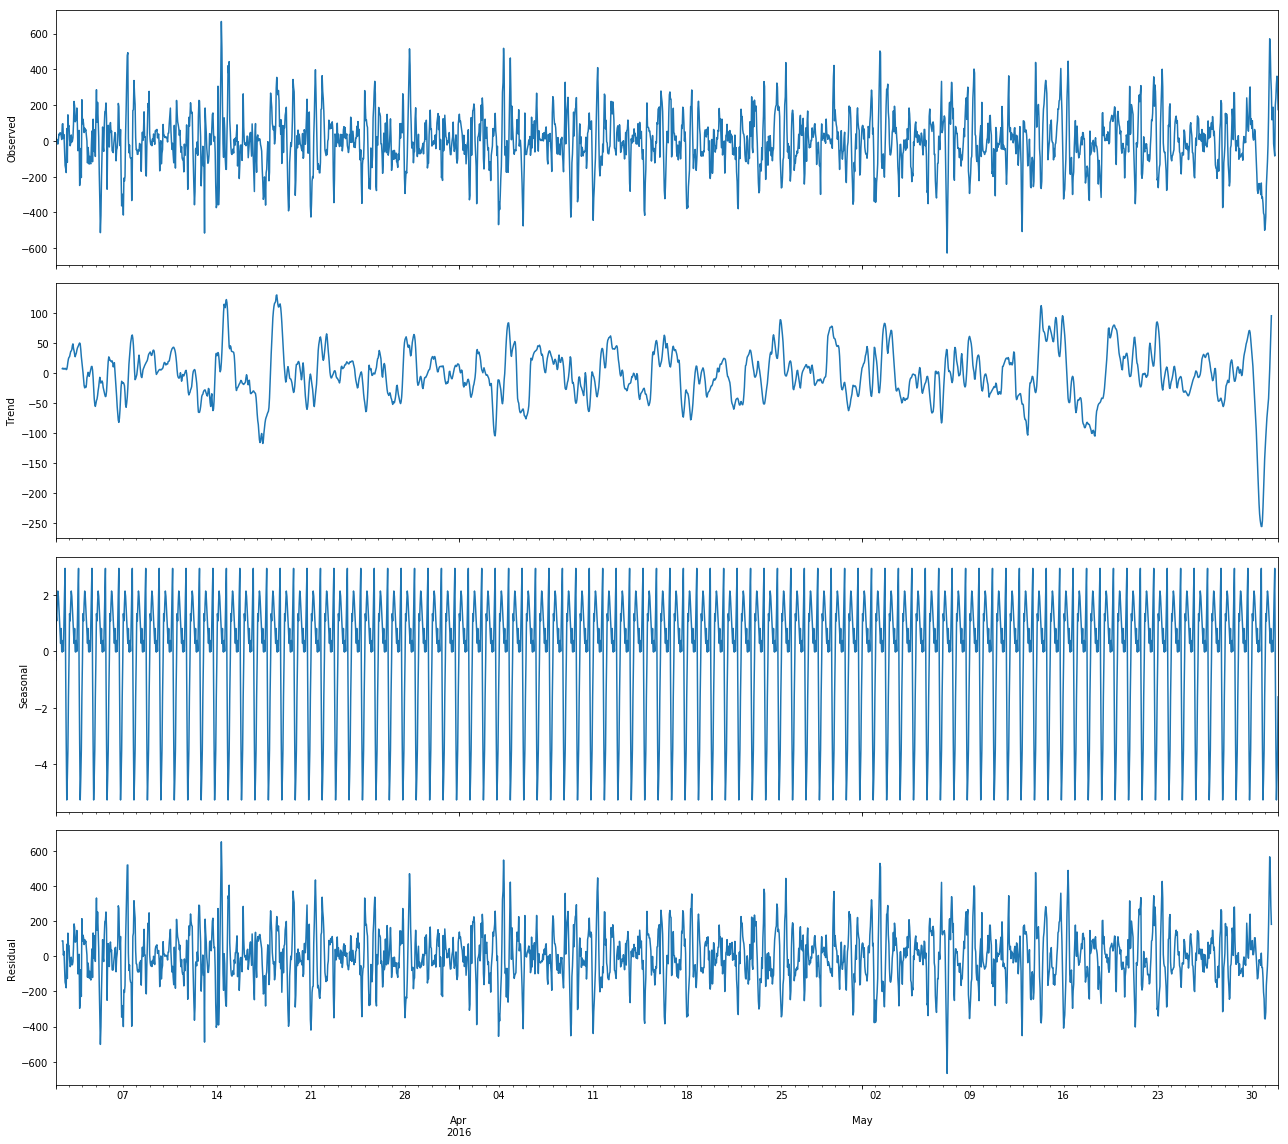

In [0]:
#применим диференцирование ряда со сдвигом на 24 часа
data['diff_poly'] = data.remains - data.remains.shift(24)

figure(figsize(18,16))
sm.tsa.seasonal_decompose(data['diff_poly'].dropna()).plot()
show()

<Figure size 1296x1152 with 0 Axes>

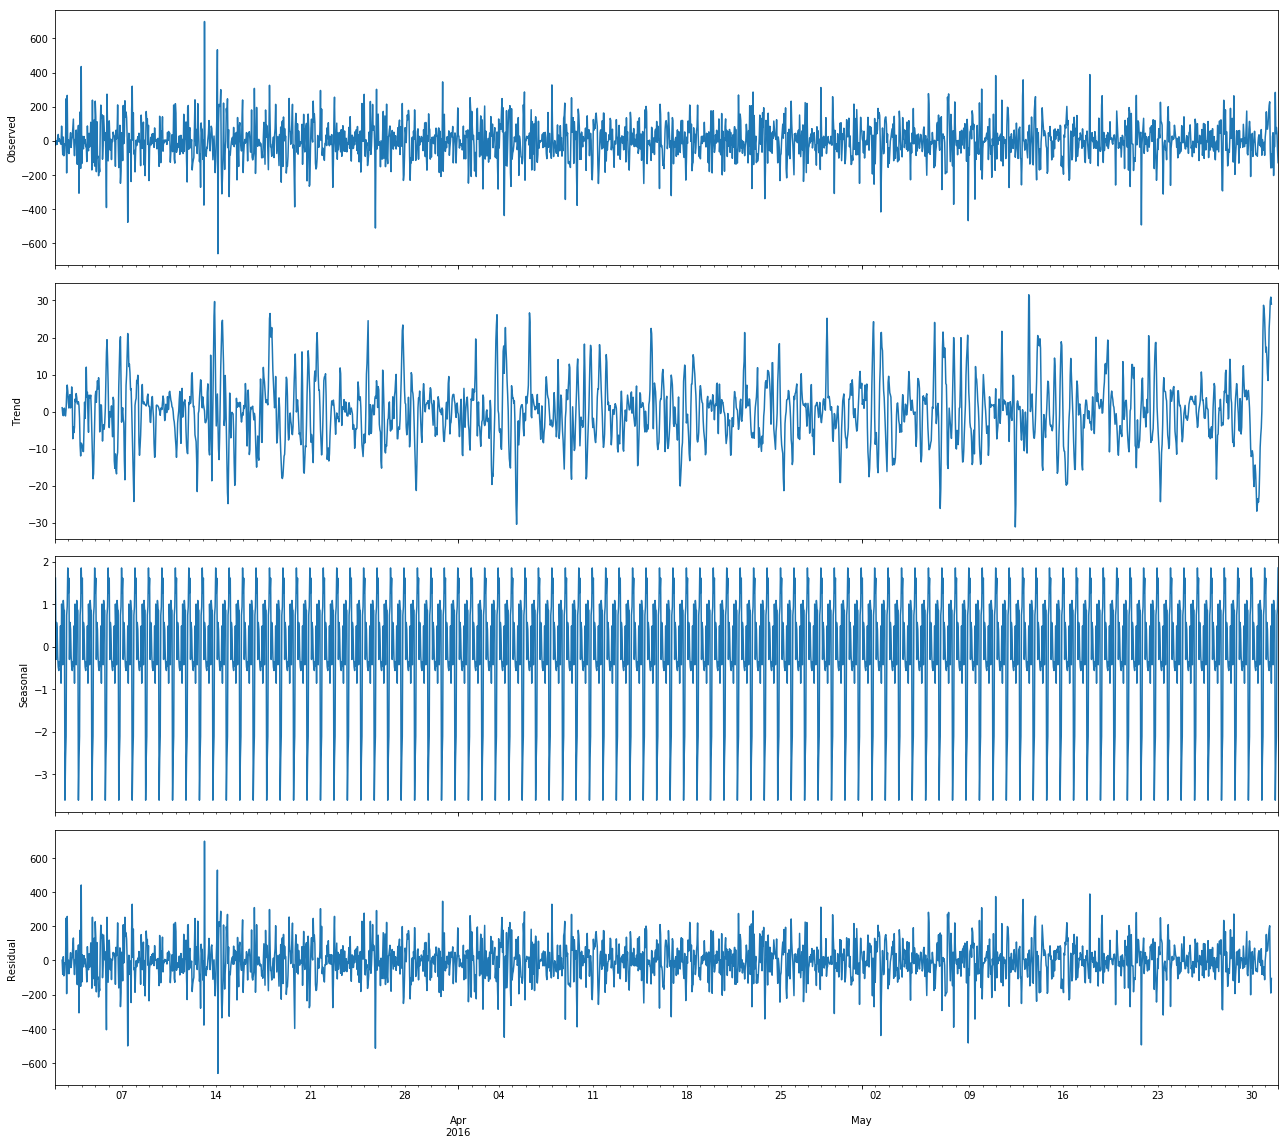

In [0]:
#применим диференцирование ряда со сдвигом на 1 час
data['diff_poly'] = data.diff_poly - data.diff_poly.shift(1)

figure(figsize(18,16))
sm.tsa.seasonal_decompose(data['diff_poly'].dropna()).plot()
show()

<Figure size 1296x1152 with 0 Axes>

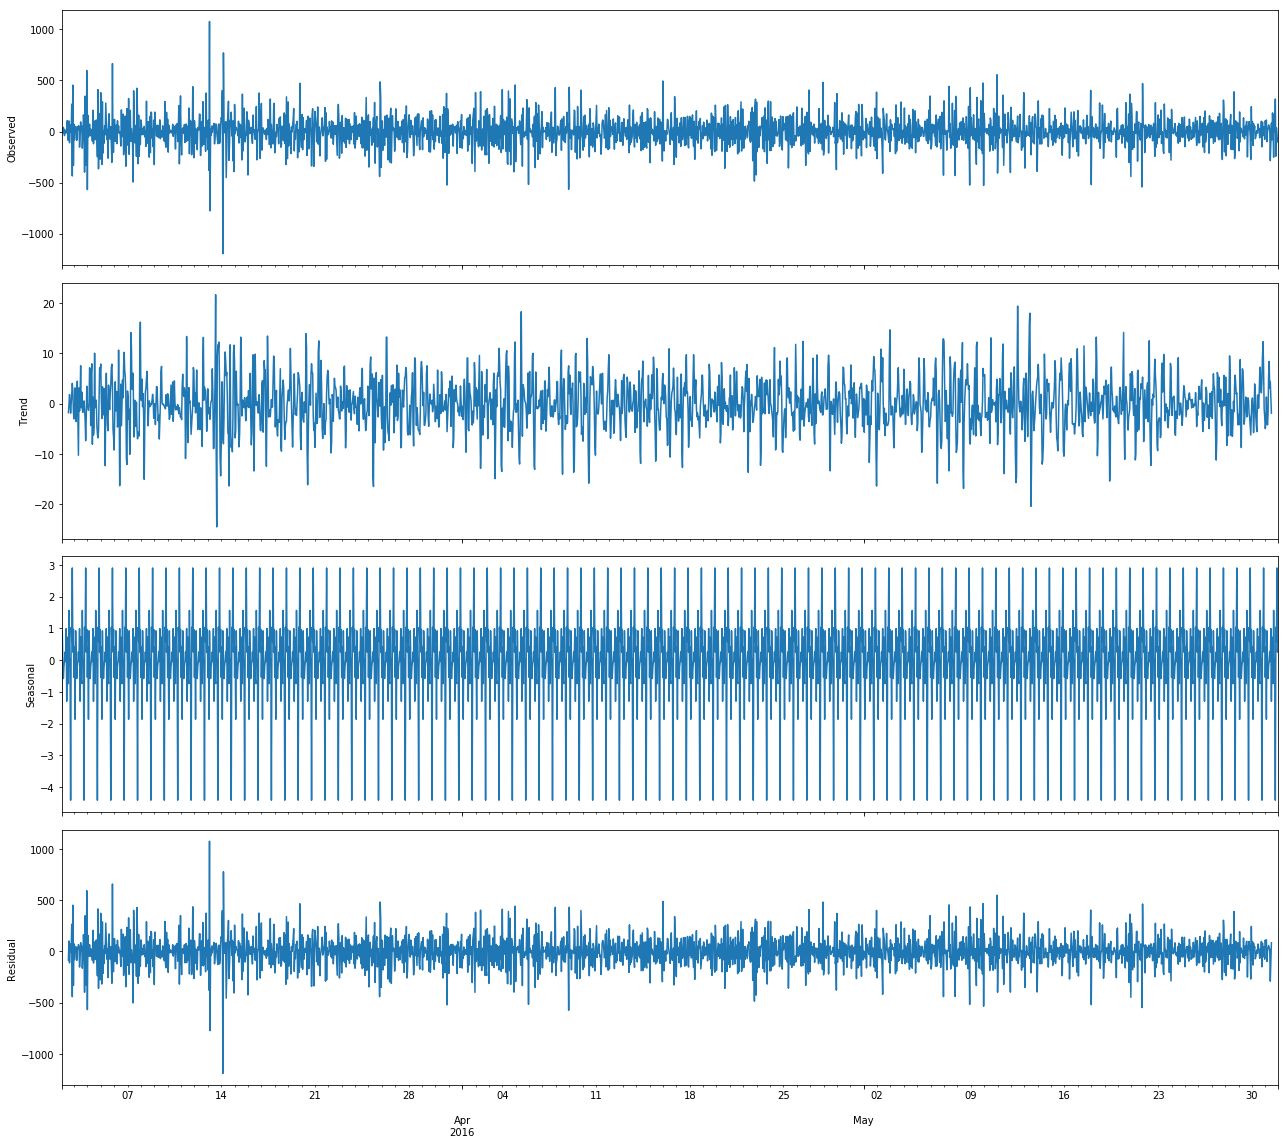

In [0]:
#применим диференцирование ряда со сдвигом на 1 час
data['diff_poly'] = data.diff_poly - data.diff_poly.shift(1)

figure(figsize(18,16))
sm.tsa.seasonal_decompose(data['diff_poly'].dropna()).plot()
show()

<Figure size 2160x720 with 0 Axes>

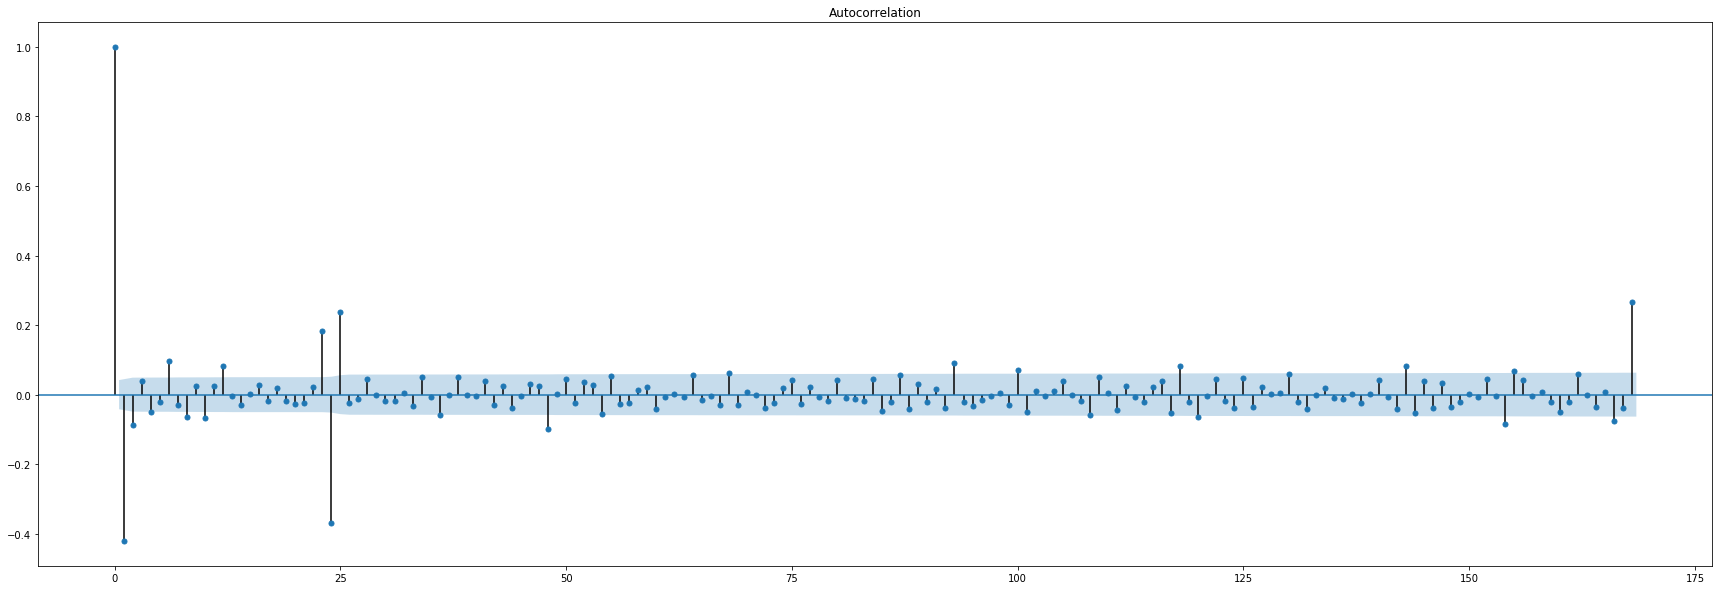

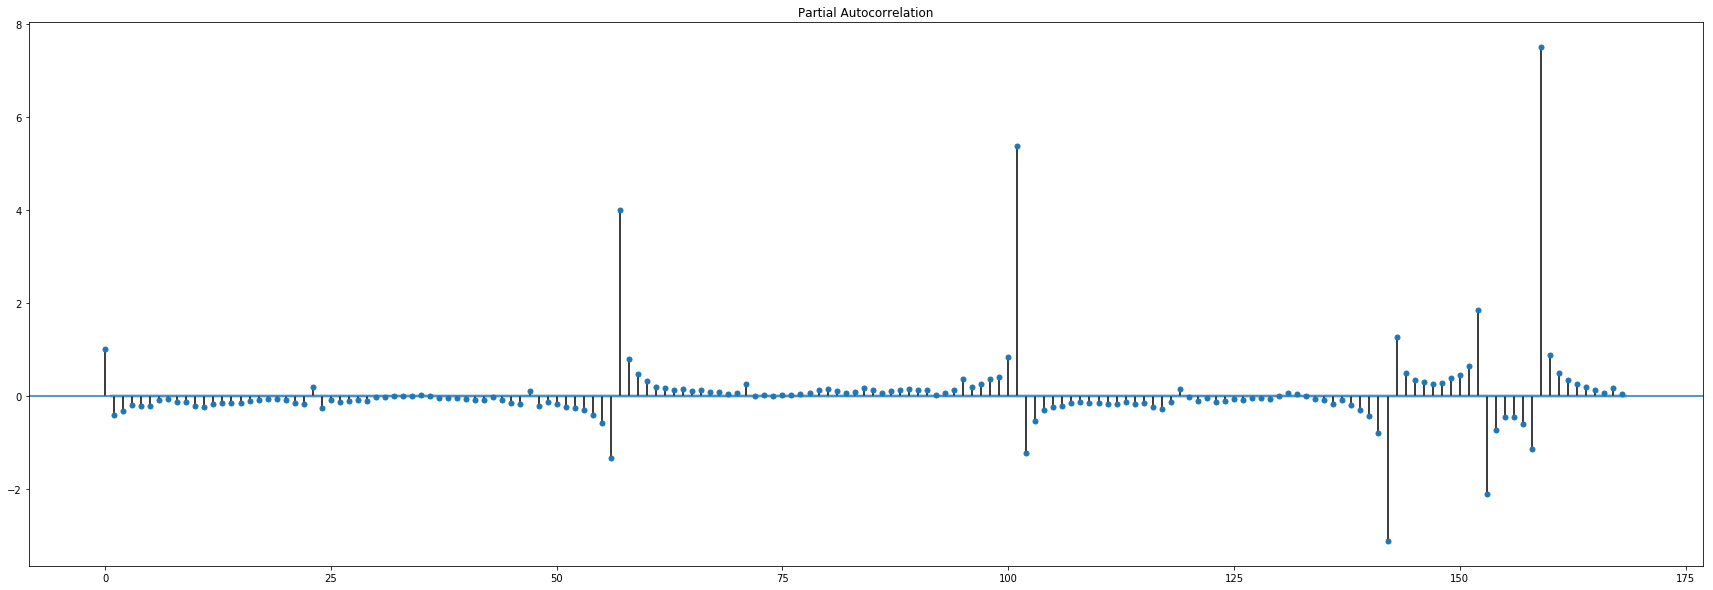

In [0]:
import statsmodels.api as sm
#ACF и PACF полученного ряда остатков
figure(figsize(30,10))
sm.graphics.tsa.plot_acf(data['diff_poly'].dropna().values, lags=168)
sm.graphics.tsa.plot_pacf(data['diff_poly'].dropna().values, lags=168)
show()

In [0]:
#Диапазон значения для моделей

import warnings
from itertools import product

ps = range(0, 3)
d=2
qs = range(0, 3)
Ps = range(0, 2)
D=1
Qs = range(0, 2)

parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
print "MODELS: ", len(parameters_list)

MODELS:  36


In [0]:
#Перебор моделей
%%time
results = []
best_aic = float("inf")
warnings.filterwarnings('ignore')

for param in parameters_list:
  #try except нужен, потому что на некоторых наборах параметров модель не обучается
  try:
      model=sm.tsa.statespace.SARIMAX(data['remains'].dropna(),
                                      order=(param[0], d, param[1]), 
                                      seasonal_order=(param[2], D, param[3], 24)).fit(disp=-1)
  #выводим параметры, на которых модель не обучается и переходим к следующему набору
  except Exception:
    print('Exception: ', param)
    continue        
  else:
    print(param, model.aic)
  aic = model.aic
  #сохраняем лучшую модель, aic, параметры
  if aic < best_aic:
      best_model = model
      best_aic = aic
      best_param = param
  results.append([param, model.aic])
  
warnings.filterwarnings('default')

result_table = pd.DataFrame(results)
result_table.columns = ['parameters', 'aic']
print(result_table.sort_values(by = 'aic', ascending=True).head())

print(best_model.summary())

((0, 0, 0, 0), 28113.62604605944)
((0, 0, 0, 1), 27101.818700562828)
((0, 0, 1, 0), 27791.90150056719)
((0, 0, 1, 1), 27050.637719451493)
((0, 1, 0, 0), 26739.400820141687)
((0, 1, 0, 1), 26022.713793745326)
((0, 1, 1, 0), 26609.94544185816)
((0, 1, 1, 1), 25860.492904264418)
((0, 2, 0, 0), 26732.61503767456)
((0, 2, 0, 1), 25950.937189443954)
((0, 2, 1, 0), 26572.168753568472)
((0, 2, 1, 1), 25824.79542406072)
((1, 0, 0, 0), 27689.869075660303)
((1, 0, 0, 1), 26795.922935786002)
((1, 0, 1, 0), 27461.67357867537)
((1, 0, 1, 1), 26698.595580727506)
((1, 1, 0, 0), 26734.213109452303)
((1, 1, 0, 1), 25958.00863525866)
((1, 1, 1, 0), 26578.30928953727)
((1, 1, 1, 1), 25829.532469019017)
((1, 2, 0, 0), 26695.68986300929)
((1, 2, 0, 1), 25802.68768924715)
((1, 2, 1, 0), 26574.319068565528)
((1, 2, 1, 1), 25864.47131810745)
((2, 0, 0, 0), 27453.992089737032)
((2, 0, 0, 1), 26628.87367260563)
((2, 0, 1, 0), 27256.402374346675)
((2, 0, 1, 1), 26508.15956826152)
((2, 1, 0, 0), 26716.375284107144

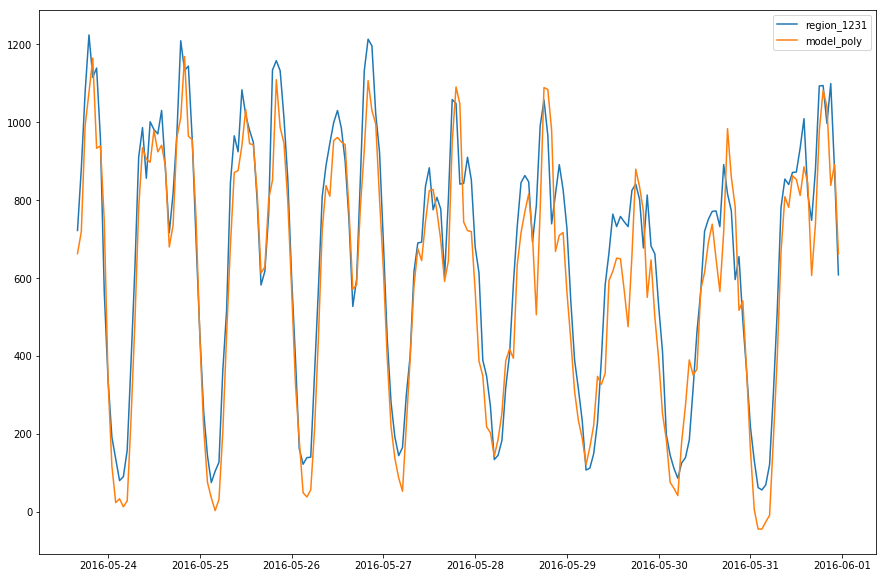

In [0]:
data['model_poly'] = best_model.fittedvalues + data.predict_poly

figure(figsize=(15,10))
plot(data.index[-200:],data.region_1231[-200:])
plot(data.index[-200:],data.model_poly[-200:])
#plot(data.index[-400:],data.predict_poly[-400:])
legend()
show()

Ну такое себе предсказание плучилось...попробуемулучшить на следующей неделе :)